In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures

In [2]:
# full_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50.],'lonlim':[0.,20.]}
full_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[42.,49.],'lonlim':[2.,18.]}
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
# ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/MARgrid_EUl.nc')
lon = ds.LON.data
lat = ds.LAT.data
H = ds.SH.data

lon_ = ds.LON.data[jmin:jmax,imin:imax]
lat_ = ds.LAT.data[jmin:jmax,imin:imax]
H_ = ds.SH.data[jmin:jmax,imin:imax]

ds = xr.open_dataset('/bettik/menegozm/EURO4M_APGD/06-coord_lonlat.nc')
lon_APGD , lat_APGD = ds.Longitude.data , ds.Latitude.data

In [4]:
ds_pr = xr.open_mfdataset('/bettik/philinat/EURO4M_APGD/APGD_*.nc')
# ds_pr = xr.open_dataset('/bettik/philinat/EURO4M_APGD/APGD_'+str(year)+'.nc')
prec_APGD = np.array(ds_pr.PRECIPITATION.data)
print(np.shape(prec_APGD))

(13880, 138, 243)


In [6]:
maxs = np.nanmax(prec_APGD,axis=(1,2))
print(np.shape(maxs))
events = prec_APGD[maxs>100,:,:]
print(np.shape(events))

(13880,)
(1893, 138, 243)


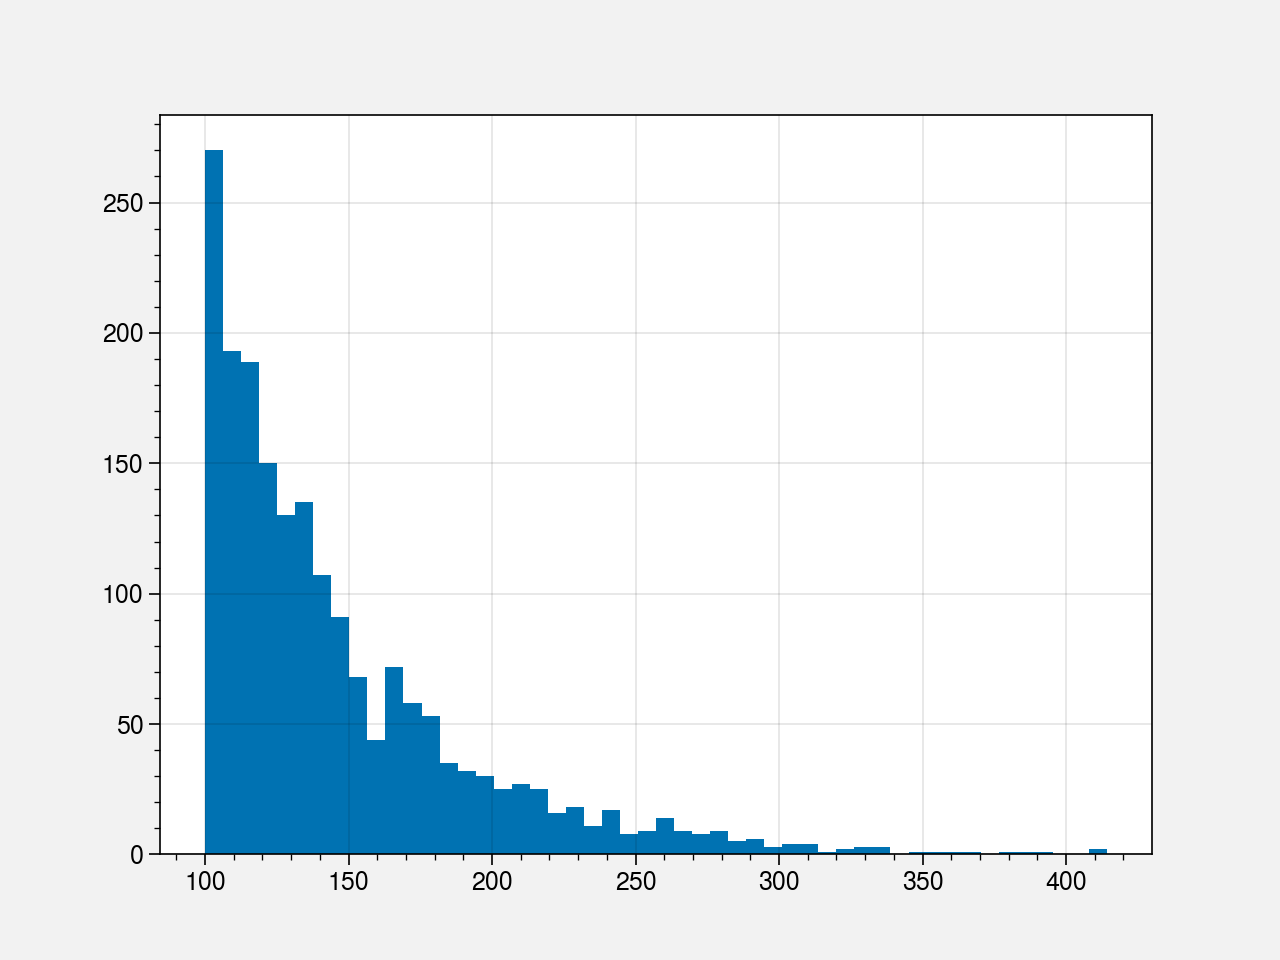

In [ ]:
plt.hist(np.nanmax(events,axis=(1,2)),bins=50)
plt.show()

In [9]:
from numba import njit,prange
@njit(parallel=True)
def get_distances(events):
    ne,nlat,lon = np.shape(events)
    distances = np.zeros((ne,ne))
    for i in range(ne):
        for j in prange(ne):
            if j<i:
                distances[i,j] = distances[j,i]
            elif j>i:
                x=events[i]#-np.nanmean(events[i])
                y=events[j]#-np.nanmean(events[j])
                distances[i,j] = 1- np.nansum(x*y) / np.sqrt(np.nansum(x**2)*np.nansum(y**2))
            elif j==i:
                distances[i,j]=1.
    return distances

In [10]:
distances = get_distances(events)

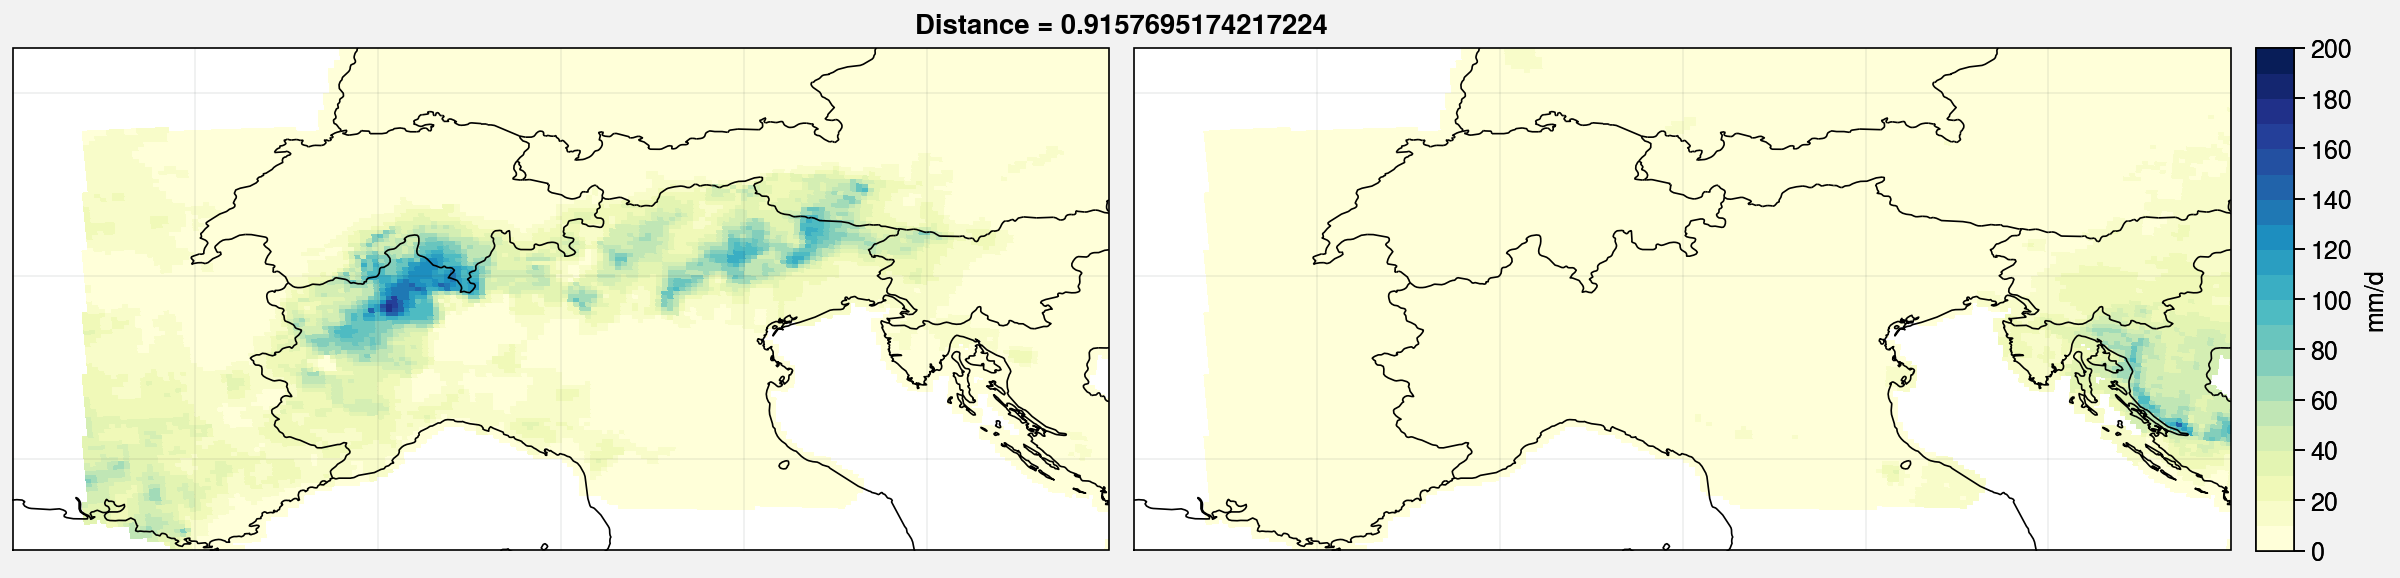

In [21]:
i,j = np.random.randint(0,len(events)-1,2)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=1,width=12)
axs[0].pcolormesh(lon_APGD,lat_APGD,events[i],levels=np.linspace(0,200,21),cmap='YlGnBu')
cb_prec = axs[1].pcolormesh(lon_APGD,lat_APGD,events[j],levels=np.linspace(0,200,21),cmap='YlGnBu')

f.colorbar(cb_prec,label= 'mm/d')
axs.format(**multiplot_format,suptitle='Distance = '+str(distances[i,j]))

In [13]:
def get_clusters(distances,threshold):
    ne,_ = np.shape(distances)
    cluster_dist = np.copy(distances)
    clusters = [ [i] for i in range(ne)]
    
    for i in range(ne-1):
        if i%10==0: print(i,end=' ')
        min_dist = np.min(cluster_dist)
        k,l = np.where( cluster_dist==min_dist )[0][:2]
        if k>l: k,l=l,k
        nk = len(clusters[k]) ; nl = len(clusters[l])
        clusters[k] += clusters.pop(l)
        cluster_dist[k,:] = (nk*cluster_dist[k,:] + nl*cluster_dist[l,:])/(nk+nl)
        cluster_dist[:,k] = (nk*cluster_dist[:,k] + nl*cluster_dist[:,l])/(nk+nl)
        cluster_dist[k,k] = 1.
        cluster_dist = np.delete(cluster_dist,l,axis=0) ; cluster_dist = np.delete(cluster_dist,l,axis=1)
        
    sorted_events = clusters[0]
    cluster_dist = distances[:,sorted_events][sorted_events,:]
    clusters = [ [i] for i in sorted_events]
    coords = [ np.array([i+1.,0.]) for i in range(ne)]
    lines = np.zeros((ne-1,2,4))
    
    got_saved_clusters = False
    for i in range(ne-1):
        if i%10==0: print(i,end=' ')
        min_dist = np.min(cluster_dist)
        k,l = np.where( cluster_dist==min_dist )[0][:2]
        if k>l: k,l=l,k
        if min_dist>threshold and not(got_saved_clusters):
            saved_clusters = [c.copy() for c in clusters]
            got_saved_clusters = True
            
        nk = len(clusters[k]) ; nl = len(clusters[l])
        clusters[k] += clusters.pop(l)
        lines[i] = np.array([[coords[k][0],coords[k][0],coords[l][0],coords[l][0]],[coords[k][1],min_dist,min_dist,coords[l][1]]])
        coords[k] = np.array([ (coords[k][0]+coords[l][0])/2 , min_dist]) ; coords.pop(l)
        cluster_dist[k,:] = (nk*cluster_dist[k,:] + nl*cluster_dist[l,:])/(nk+nl)
        cluster_dist[:,k] = (nk*cluster_dist[:,k] + nl*cluster_dist[:,l])/(nk+nl)
        cluster_dist[k,k] = 1.
        cluster_dist = np.delete(cluster_dist,l,axis=0) ; cluster_dist = np.delete(cluster_dist,l,axis=1)
    return saved_clusters,lines,sorted_events

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 

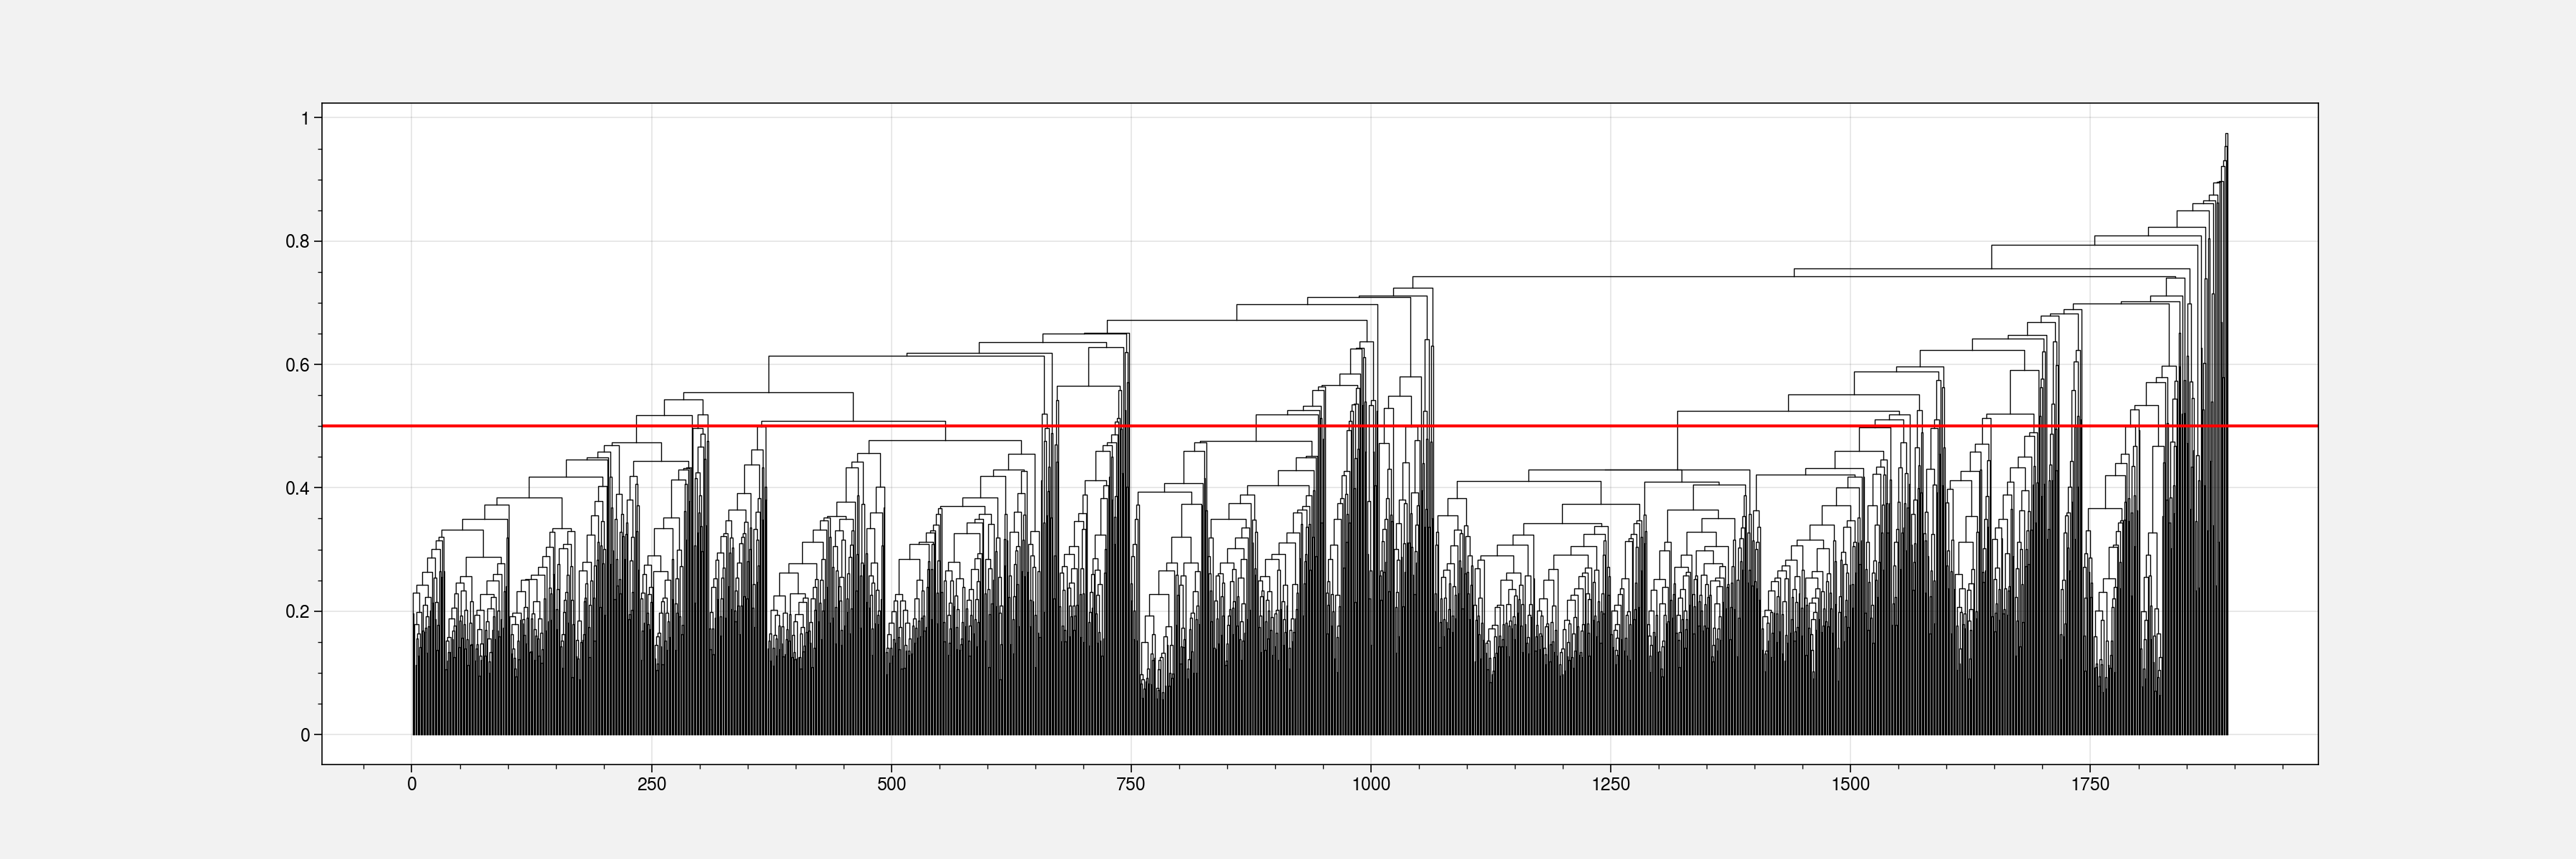

In [14]:
threshold = 0.5
clusters,lines,sorted_events = get_clusters(distances,threshold)
plt.figure(figsize=(18,6))
for i in range(len(lines)):
    plt.plot(lines[i,0,:],lines[i,1,:],color='k',linewidth=0.5)
plt.axhline(threshold, color='r', linestyle='-')
plt.show()

In [15]:
print([len(c) for c in clusters])
print(len(events),sum([len(c) for c in clusters]))

[291, 1, 15, 2, 61, 285, 2, 8, 3, 5, 1, 62, 1, 1, 3, 1, 1, 1, 2, 1, 1, 196, 1, 1, 1, 2, 2, 1, 27, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 2, 6, 2, 2, 1, 1, 15, 1, 28, 1, 3, 4, 2, 3, 1, 331, 146, 18, 2, 10, 3, 16, 2, 1, 2, 2, 47, 1, 49, 1, 1, 1, 2, 2, 1, 1, 7, 1, 3, 1, 1, 15, 3, 2, 1, 1, 1, 1, 58, 2, 26, 1, 2, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 6, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1893 1893


In [16]:
freq = np.array([len(c) for c in clusters])
sort = np.argsort(freq)[::-1]
freq = freq[sort]
centroids = np.array([np.mean(events[c],0) for c in clusters])[sort]

In [19]:
def show_clustering(ncols=3, nrows=3,title=''):
    f, axs = pplt.subplots(proj='cyl',ncols=ncols, nrows=nrows,width=12)
    for i in range(min(ncols*nrows,len(centroids))):
        cb_prec=axs[i].pcolormesh(lon_APGD,lat_APGD,centroids[i],levels=np.linspace(0,100,21),cmap='YlGnBu')
        axs[i].format(title=str(np.around(100*freq[i]/np.sum(freq),1))+' %',titlesize='20px')

    f.colorbar(cb_prec,label= 'mm/d')
    axs.format(**multiplot_format,suptitle=title)

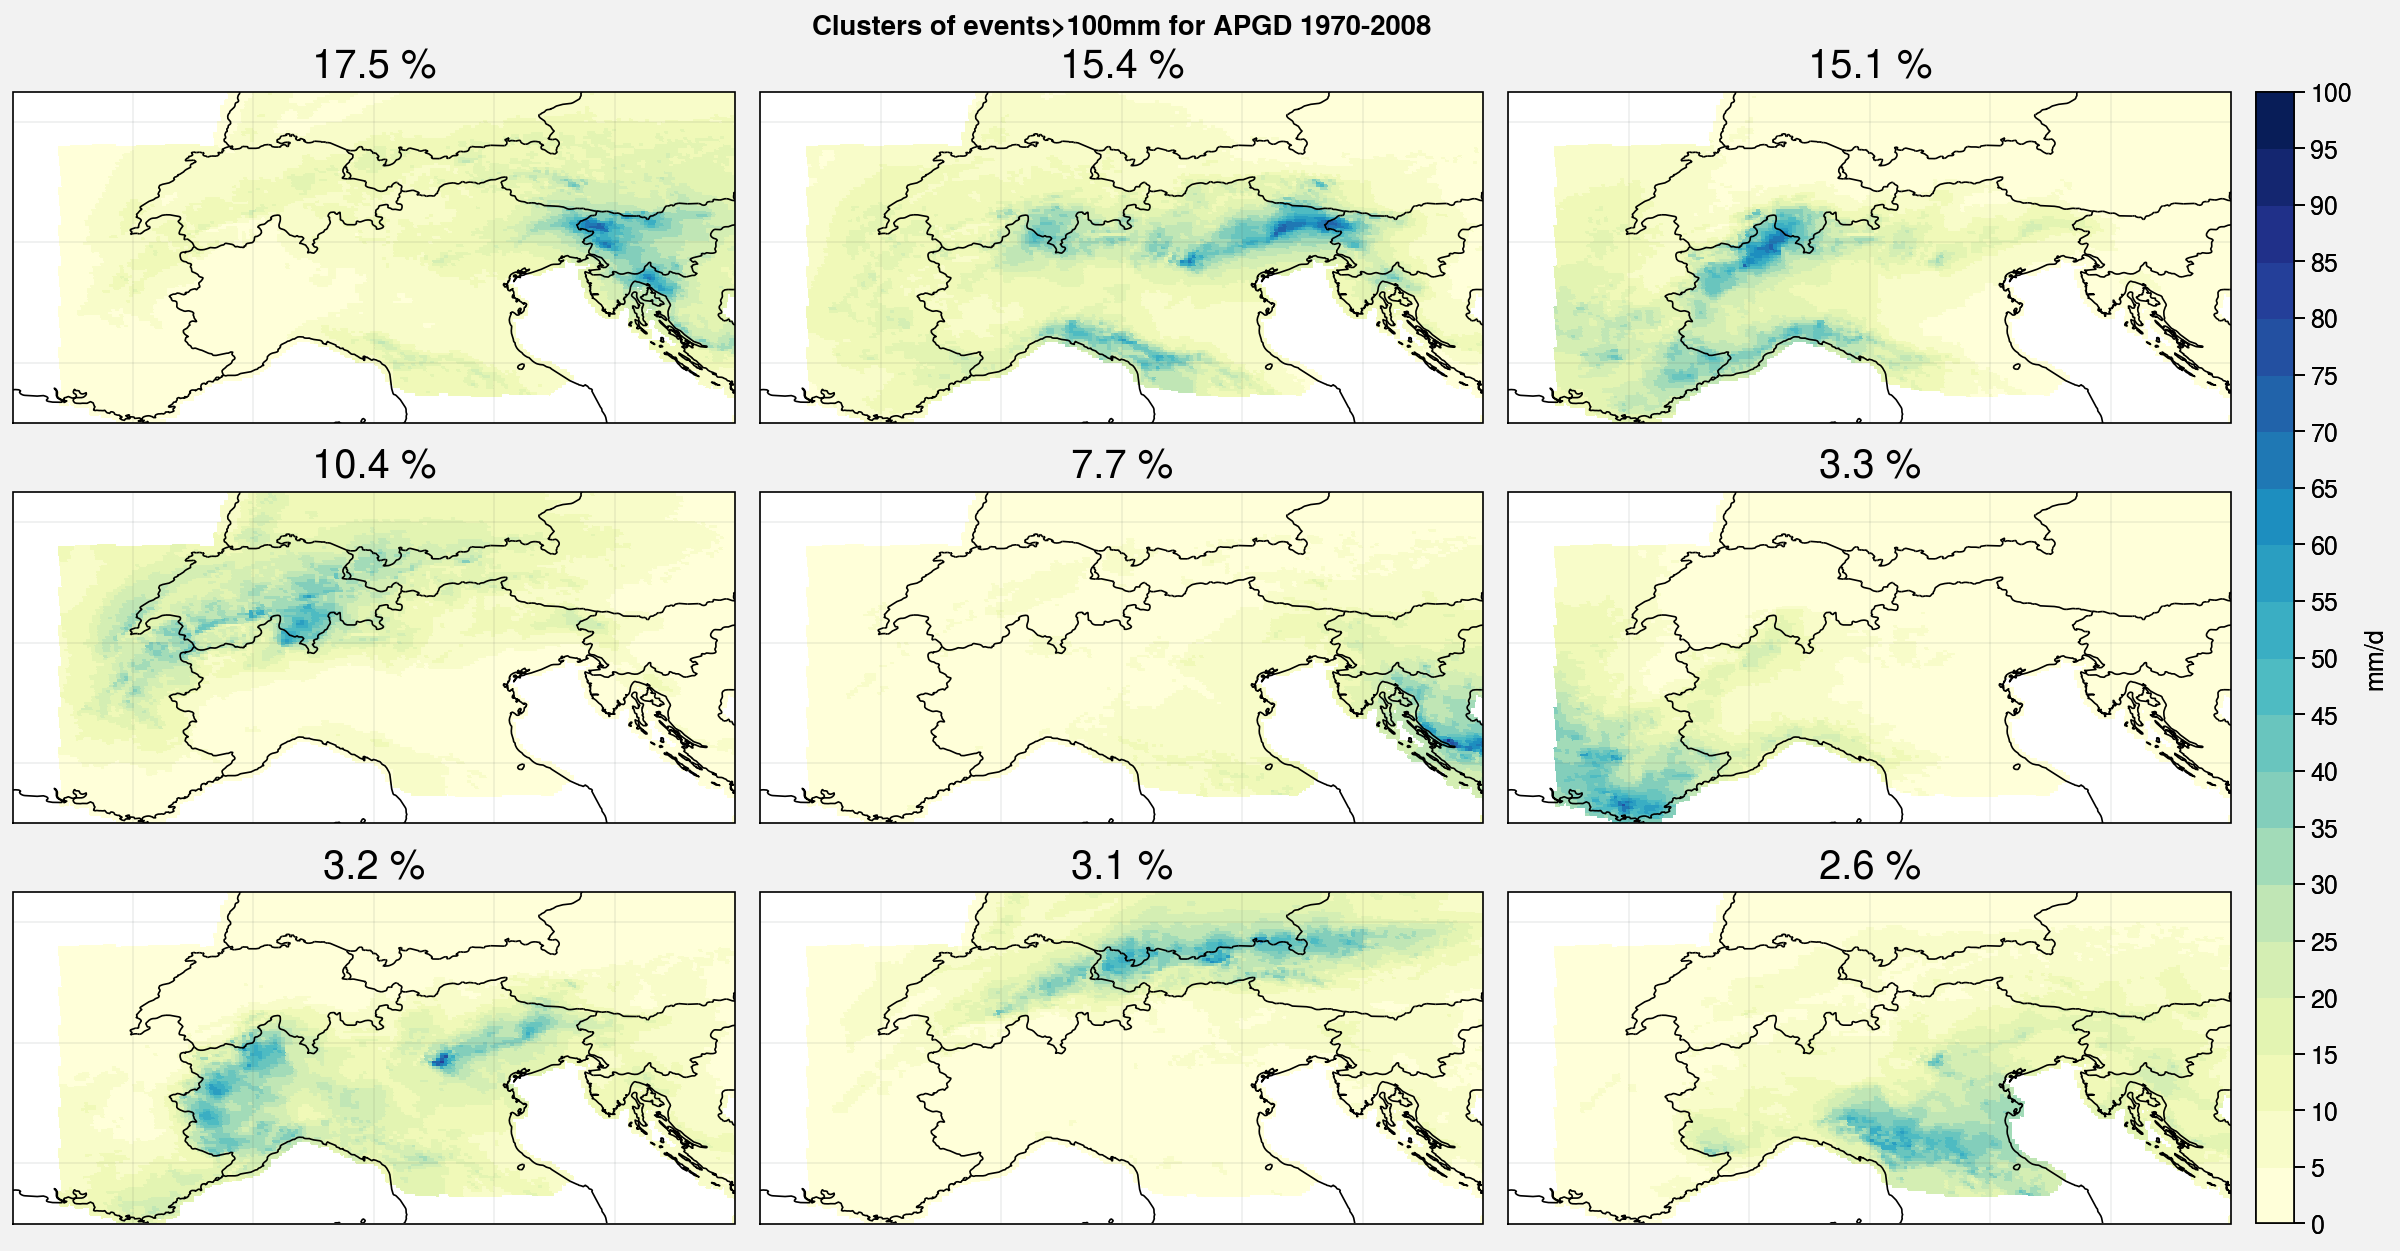

In [20]:
show_clustering(title='Clusters of events>100mm for APGD 1970-2008')

In [46]:
def distance(a,b):
    x=a-np.nanmean(a)
    y=b-np.nanmean(b)
    return 1- np.nansum(x*y) / np.sqrt(np.nansum(x**2)*np.nansum(y**2))

def centroid_plus_proche(a,liste_centroids):
    imin = 0
    dmin = distance(a,liste_centroids[0])
    for i,c in enumerate(liste_centroids[1:],1):
        d = distance(a,c)
        if d<dmin:
            imin = i
            dmin = d
    return imin

def kmean(points,nb_centroid):
    centroids = points[np.random.choice(len(points),nb_centroid)] #points[:nb_centroid]#
    labels = np.array([ centroid_plus_proche(pt,centroids) for pt in points ])
    it=0
    while it <15:
        it+=1
        print(it,[ np.sum(labels==i) for i in range(nb_centroid)])
        for lb in range(nb_centroid):
            centroids[lb,:] = np.mean( points[labels==lb] ,0)
        new_labels =np.array([ centroid_plus_proche(pt,centroids) for pt in points ])
        if np.all(labels == new_labels):
            break
        else:
            labels = np.copy(new_labels)
    return centroids,labels
def afficher(points,centroids,labels):
    plt.figure()
    
    for i,pt in enumerate(points):
        plt.plot(pt[0],pt[1],'o'+colors[labels[i]])
    for lb,c in enumerate(centroids):
        plt.plot(c[0],c[1],'x'+colors[lb],markersize=15)
    plt.show()
    
# colors = ['r','g','b','k']
# points = np.random.random((20,2))
# centroids = kmean(points,2) 


In [64]:
centroids,labels = kmean(events,20)
freq = np.array([ np.sum(labels==i) for i in range(len(centroids))])
print(freq)
sort = np.argsort(freq)[::-1]
new_labels = np.copy(labels)
for i in range(len(sort)):
    new_labels[labels==sort[i]] = i
labels=new_labels
centroids = centroids[sort]
freq = np.array([ np.sum(labels==i) for i in range(len(centroids))])
print(freq)

1 [10, 34, 8, 15, 9, 16, 10, 13, 7, 11, 21, 24, 4, 9, 3, 6, 5, 20, 13, 3]
2 [8, 31, 10, 14, 10, 11, 13, 18, 6, 11, 16, 24, 5, 8, 3, 12, 10, 13, 13, 5]
3 [8, 29, 8, 14, 10, 10, 13, 19, 6, 11, 15, 26, 4, 8, 3, 13, 13, 13, 12, 6]
[ 8 29  8 14 10 10 13 19  6 11 15 26  4  8  3 13 13 13 12  6]
[29 26 19 15 14 13 13 13 13 12 11 10 10  8  8  8  6  6  4  3]
